# Face Generation
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA

We'll use MNIST to see how our model is training before training on CelebA. It'll allow things to move faster.

In [1]:
data_dir = './data'


import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST


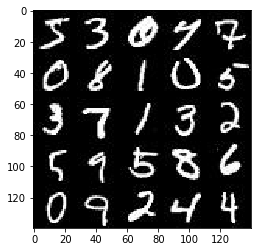

In [2]:
show_n_images = 25


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. 

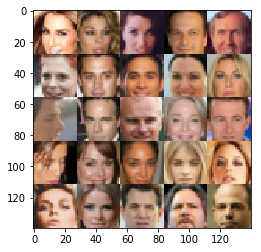

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
 The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network


### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Users/sarahhernandez/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "input_real")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name = "input_z")
    learning_rate = tf.placeholder(tf.float32)
    
    return (real_input, z_input, learning_rate)


tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/sarahhernandez/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/sarahhernandez/anaconda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/sarahhernandez/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/Users/sarahhernandez/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/sarahhernandez/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/Users/sarahhernandez/ana

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse = reuse):
        #Input shape is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = "SAME")
        relu1 = tf.nn.relu(x1)
        
        #Shape is now 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = "SAME")
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.nn.relu(bn2)
        
        #Shape is now 7x7x128, let do this one more time:
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = "SAME")
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.nn.relu(bn3)
        
        #Shape is now 4x4x256, Now flatten it:
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    
    return (output, logits)


tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator


In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse = not is_train):
        
        alpha = 0.2
        
        #First, a fully connected layer:
        x1 = tf.layers.dense(z, 7*7*256)
        
        #Reshape to start conv stack:
        x1 = tf.reshape(x1, (-1, 7,7,256))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        
        #Size is now 7x7x256, let's change that with some conv2d_transpose:
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides = 1, padding = "SAME")
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        #Size is now 7x7x128, let's add a third layer:
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides = 2, padding = "SAME")
        bn3 = tf.layers.batch_normalization(x3, training = is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        
        #Size is now 14x14x64, Let's make an output layer to get the 28x28x(out_channel_dim) we want:
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides = 2, padding = "SAME")
        output = tf.tanh(logits)
        
        #Size is now 28x28x5
        
        
    return output


tests.test_generator(generator, tf)

Tests Passed


### Loss


In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    import numpy as np
    
    #Build the models:
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    #Calculate loss of models:
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    
    
    return (d_loss, g_loss)


tests.test_model_loss(model_loss)

Tests Passed


### Optimization


In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #Get var lists:
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    #Optimize:
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
        
    
    
    return (d_train_opt, g_train_opt)

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train


In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print("training accessed")
    sample_z = np.random.uniform(-1,1,size = (64, z_dim))
    samples, losses = [], []
    steps = 0
    
    if (data_image_mode == "L"):
        num_channels = 1
    else: 
        num_channels = 3
        
    #Build the model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], num_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, num_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    print("model built")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                batch_images = batch_images * 2
                
                #Sample random noise:
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                #Run optimizers:
                _ = sess.run(d_train_opt, feed_dict = {input_real : batch_images, input_z: batch_z, learn_rate : learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z : batch_z, input_real : batch_images, learn_rate : learning_rate})
                
                
                #Sample from generator every 100 steps:
                if steps % 100 == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    losses.append((train_loss_g, train_loss_d))

                    show_generator_output(sess, 12, input_z, data_shape[3], data_image_mode)
            
                    gen_samples = sess.run(generator(input_z, num_channels, is_train=False), feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
            
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))
            
                
        
            # Sample random noise again for generator
            sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
                
    print("Training Complete")            
    return losses, samples
                
                
                
                
                
                
                
                
                
                

### MNIST


training accessed
model built


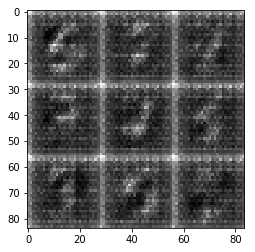

Epoch 1/2... Discriminator Loss: 0.4559... Generator Loss: 1.2401


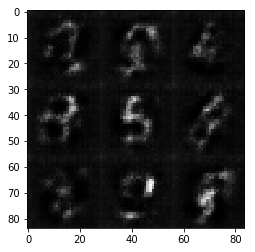

Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 2.1913


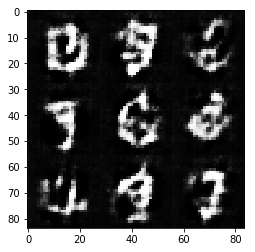

Epoch 1/2... Discriminator Loss: 0.0387... Generator Loss: 0.7767


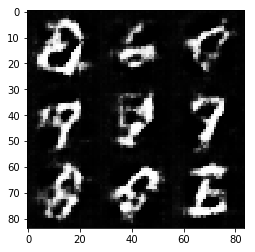

Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 0.1780


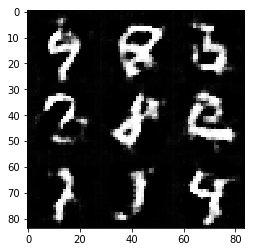

Epoch 1/2... Discriminator Loss: 0.3195... Generator Loss: 0.3223


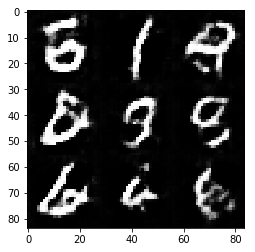

Epoch 1/2... Discriminator Loss: 0.3000... Generator Loss: 0.4546


KeyboardInterrupt: 

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA


training accessed
model built


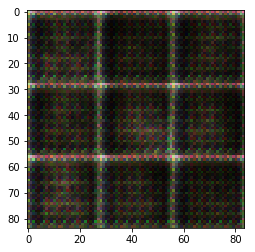

Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.2183


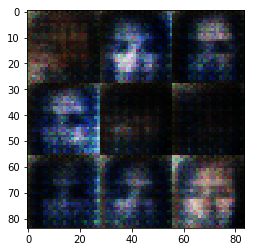

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7994


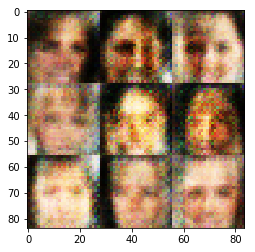

Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.4869


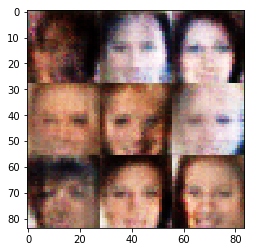

Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8791


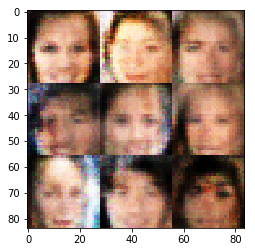

Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.9208


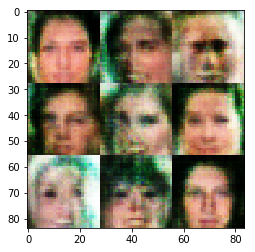

Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 2.3146


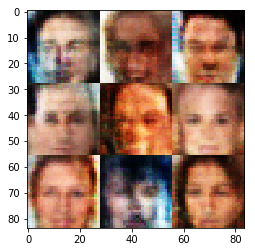

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.7883


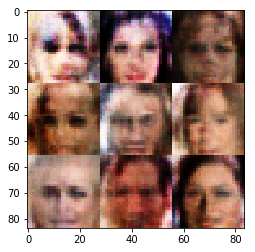

Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.4212


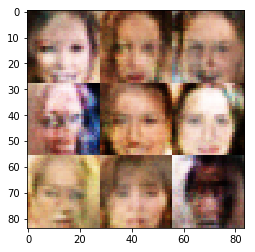

Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7333


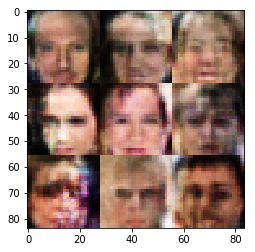

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6139


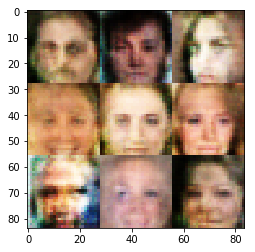

Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.5114


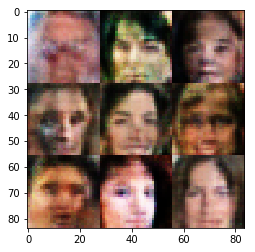

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.5141


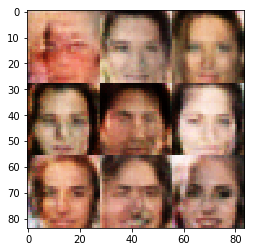

Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.6115


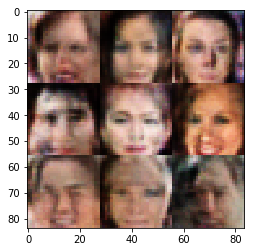

Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9232


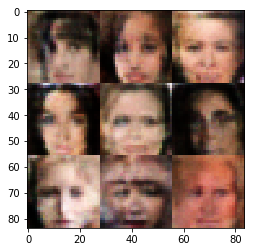

Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6646


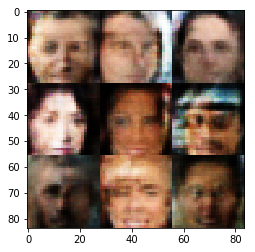

Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.2405


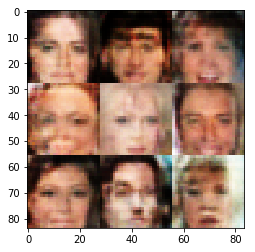

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.7035


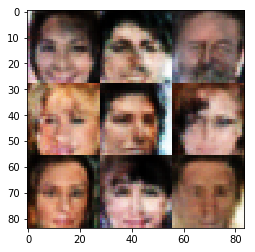

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6282


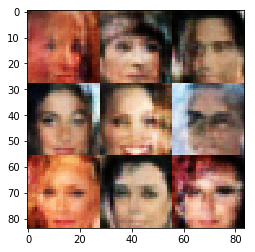

Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 1.8865


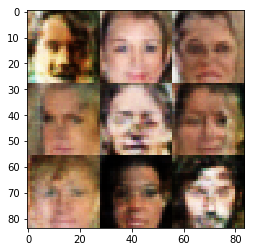

Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7489


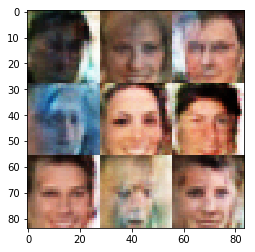

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.1266


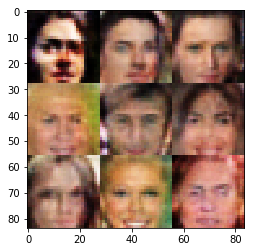

Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9220


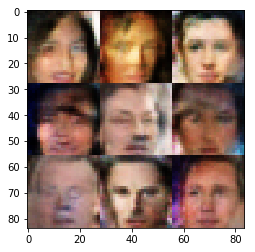

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.8277


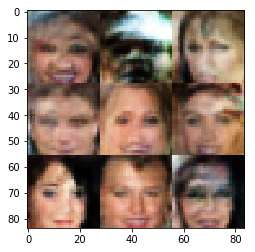

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6402


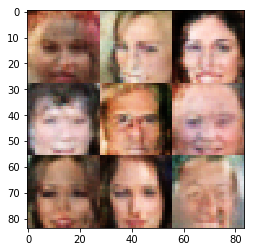

Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7395


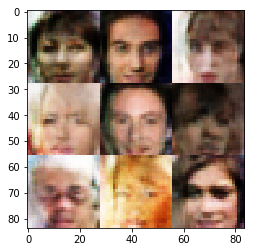

Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.3390


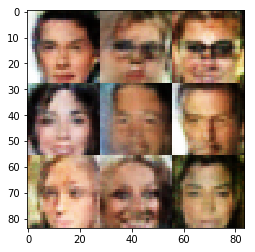

Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.4875


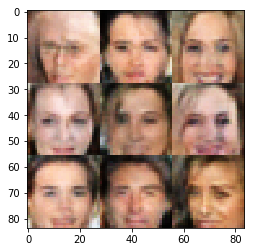

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.0460


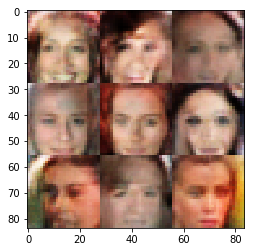

Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.3636


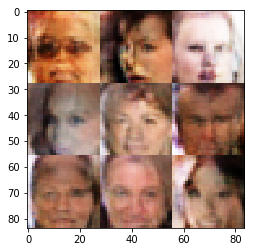

Epoch 1/1... Discriminator Loss: 1.7123... Generator Loss: 0.4076


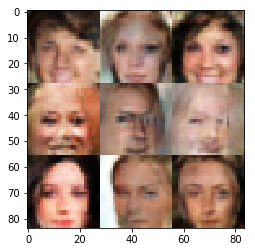

Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.2609
Training Complete


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)